# Regression Analysis for Grocery Store

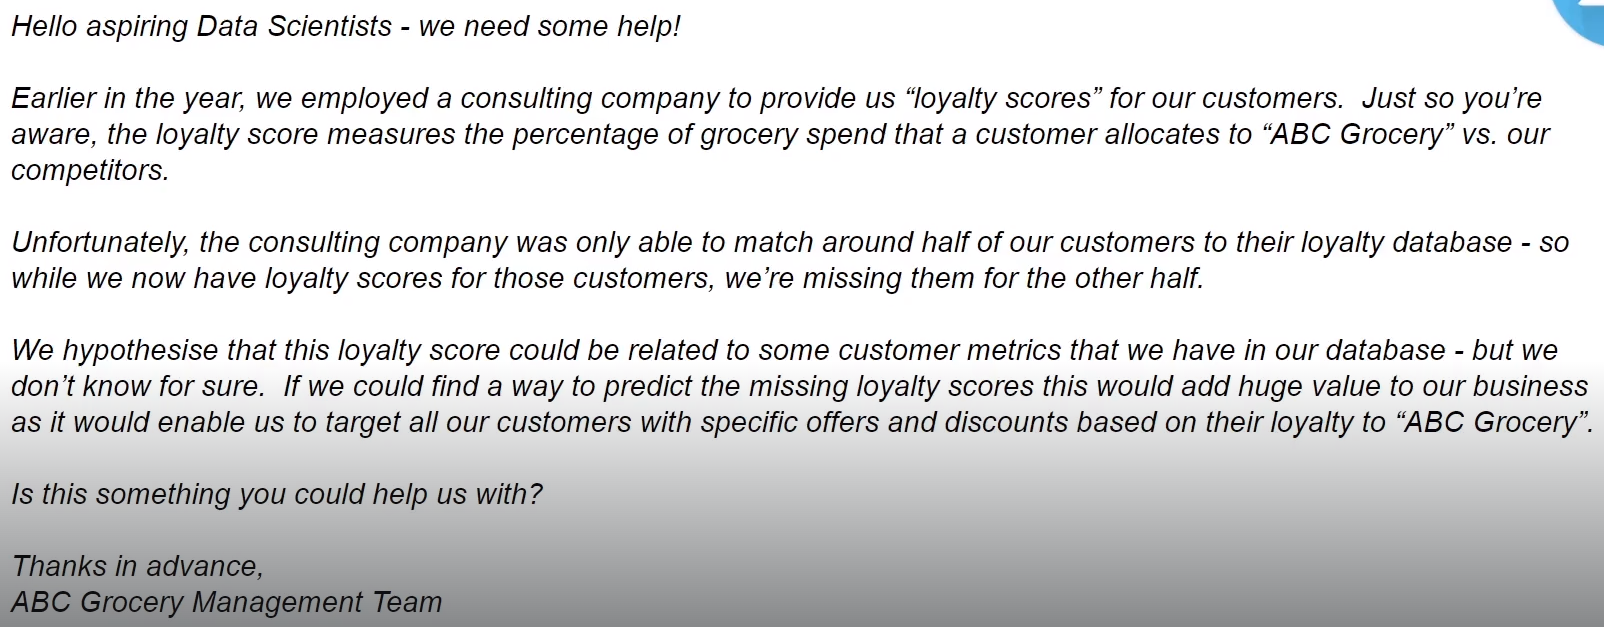

In [72]:
# import required packages
import pandas as pd
import pickle
# import required packages
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

In [4]:
# import Data
data_path = "C:/Users/eacalder/Documents/Education/DataScienceInfinity/Leasson_Downloads/ABTesting/grocery_database.xlsx"
loyalty_scores = pd.read_excel(data_path, sheet_name = 'loyalty_scores') 
customer_details = pd.read_excel(data_path, sheet_name = 'customer_details') 
transactions = pd.read_excel(data_path, sheet_name = 'transactions') 
print(loyalty_scores.shape)
loyalty_scores.head()

(400, 2)


,customer_id,customer_loyalty_score
0,104,0.587
1,69,0.156
2,525,0.959
3,181,0.418
4,796,0.570


In [7]:
print(customer_details.shape)
customer_details.head()

,customer_id,distance_from_store,gender,credit_score
0,74,3.38,F,0.59
1,524,4.76,F,0.52
2,607,4.45,F,0.49
3,343,0.91,M,0.54
4,322,3.02,F,0.63


In [6]:
print(transactions.shape)
transactions.head()

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97
3,1,2020-06-02,436189770685,1,2,38.52
4,1,2020-06-10,436265380298,4,4,22.13


In [13]:
# Create customer level data set
data_for_regression = pd.merge(customer_details,
                               loyalty_scores, 
                               how='left', 
                               on='customer_id')
print(data_for_regression.shape)
data_for_regression.head(7)
#you can clearly see some customers that do not have a loyalty score

(870, 5)


,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score
0,74,3.38,F,0.59,0.263
1,524,4.76,F,0.52,0.298
2,607,4.45,F,0.49,0.337
3,343,0.91,M,0.54,0.873
4,322,3.02,F,0.63,0.350
5,115,1.02,M,0.64,0.751
6,1,4.78,F,0.66,NaN


In [17]:
sales_summary =  transactions.groupby('customer_id').agg({'sales_cost':'sum',
                                                          'num_items':'sum',
                                                          'transaction_id':'count',
                                                          'product_area_id': 'nunique'}).reset_index()
print(sales_summary.shape)
sales_summary.head()

(870, 5)


,customer_id,sales_cost,num_items,transaction_id,product_area_id
0,1,3980.49,424,51,5
1,2,2056.91,213,52,5
2,3,324.22,65,12,4
3,4,3499.39,278,47,5
4,5,6609.19,987,106,5


In [19]:
sales_summary.columns = ['customer_id', 'total_sales','total_items','transaction_count', 'product_area_count']
print(sales_summary.shape)
sales_summary.head()

(870, 5)


,customer_id,total_sales,total_items,transaction_count,product_area_count
0,1,3980.49,424,51,5
1,2,2056.91,213,52,5
2,3,324.22,65,12,4
3,4,3499.39,278,47,5
4,5,6609.19,987,106,5


In [20]:
sales_summary['avg_basket_value'] = sales_summary['total_sales']/sales_summary['transaction_count']
print(sales_summary.shape)
sales_summary.head()

(870, 6)


,customer_id,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
0,1,3980.49,424,51,5,78.048824
1,2,2056.91,213,52,5,39.555962
2,3,324.22,65,12,4,27.018333
3,4,3499.39,278,47,5,74.455106
4,5,6609.19,987,106,5,62.350849


In [21]:
data_for_regression_2 = pd.merge(data_for_regression,
                               sales_summary, 
                               how='inner', 
                               on='customer_id')
print(data_for_regression_2.shape)
data_for_regression_2.head(7)
# managed to gather all metrics that will help the machine 
# learning model to predict the other 
# half of the customers loyalty score

(870, 10)


,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800
5,115,1.02,M,0.64,0.751,2490.66,263,51,5,48.836471
6,1,4.78,F,0.66,NaN,3980.49,424,51,5,78.048824


In [22]:
regression_modeling = data_for_regression_2.loc[data_for_regression_2['customer_loyalty_score'].notna()]
regression_scoring = data_for_regression_2.loc[data_for_regression_2['customer_loyalty_score'].isna()]
print(regression_modeling.shape)
regression_modeling.head()

(400, 10)


,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [23]:
print(regression_scoring.shape)
regression_scoring.head()

(470, 10)


,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
6,1,4.78,F,0.66,NaN,3980.49,424,51,5,78.048824
7,120,3.49,F,0.38,NaN,2887.20,253,45,5,64.160000
8,52,14.91,F,0.68,NaN,3342.75,335,47,5,71.122340
10,435,0.25,M,0.62,NaN,2326.71,267,48,5,48.473125
12,679,4.74,F,0.58,NaN,3448.59,370,49,5,70.379388


In [24]:
regression_scoring.drop(['customer_loyalty_score'],axis=1,inplace=True)
print(regression_scoring.shape)
regression_scoring.head()

(470, 9)


C:\Users\eacalder\AppData\Local\Temp\1/ipykernel_13528/3055292113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_scoring.drop(['customer_loyalty_score'],axis=1,inplace=True)


,customer_id,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
6,1,4.78,F,0.66,3980.49,424,51,5,78.048824
7,120,3.49,F,0.38,2887.20,253,45,5,64.160000
8,52,14.91,F,0.68,3342.75,335,47,5,71.122340
10,435,0.25,M,0.62,2326.71,267,48,5,48.473125
12,679,4.74,F,0.58,3448.59,370,49,5,70.379388


In [27]:
# save our files
pickle.dump(regression_modeling,open('Saved_files/Groc_regression_modeling.p','wb'))
pickle.dump(regression_scoring,open('Saved_files/Groc_regression_scoring.p','wb'))

In [58]:
# import, learning to import using pickle files
data_for_model = pickle.load(open('Saved_files/Groc_regression_modeling.p','rb'))

# we dont really need the id for the model
data_for_model.drop('customer_id', axis=1, inplace=True)
print(data_for_model.shape)
data_for_model.head()


(400, 9)


,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
0,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [59]:
# shuffle data just in case it either came in in some order
# or we accidentally ordered it which will cause model to error
data_for_model = shuffle(data_for_model,random_state=42)
print(data_for_model.shape)
data_for_model.head()

(400, 9)


,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
455,0.28,M,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,F,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,M,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,M,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,F,0.67,0.297,1904.55,376,36,3,52.904167


In [60]:
######################################################
# deal with missing values
######################################################
data_for_model.isna().sum()
# small number of columns with missing values, lets not impute and just drop 
# but noted 

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
avg_basket_value          0
dtype: int64

In [61]:
# "any" meaning drop the whole row if any one cell is empty
data_for_model.dropna(how="any", inplace=True)
print(data_for_model.shape)
data_for_model.head()

(394, 9)


,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
455,0.28,M,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,F,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,M,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,M,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,F,0.67,0.297,1904.55,376,36,3,52.904167


In [62]:
######################################################
# deal with outliers
######################################################
outlier_investigation = data_for_model.describe()
print(outlier_investigation)
# some outliers in distance_from_store, total_sales, total_items
# all others did not spark any issues

       distance_from_store  credit_score  customer_loyalty_score  total_sales  \
count           394.000000    394.000000              394.000000   394.000000   
mean              2.021041      0.596117                0.509589  1846.502538   
std               2.566045      0.101352                0.294504  1767.829482   
min               0.000000      0.260000                0.002000    45.950000   
25%               0.710000      0.530000                0.263000   942.067500   
50%               1.645000      0.590000                0.510500  1471.490000   
75%               2.910000      0.660000                0.771500  2104.727500   
max              44.370000      0.880000                1.000000  9878.760000   

       total_items  transaction_count  product_area_count  avg_basket_value  
count   394.000000         394.000000          394.000000        394.000000  
mean    278.304569          44.926396            4.312183         36.781487  
std     214.236424          21.24801

In [63]:
#boxplot approach
outlier_columns = ["distance_from_store", "total_sales", "total_items"]
for column in outlier_columns:
    lower_quartile = data_for_model[column].quantile(.25)
    upper_quartile = data_for_model[column].quantile(.75)
    iqr= upper_quartile - lower_quartile
    iqr_extend = iqr *2 # 1.5 reason i dont want to cut out too many outliers
    min_border = lower_quartile - iqr_extend
    max_border = upper_quartile + iqr_extend

    outliers = data_for_model[(data_for_model[column]<min_border)|(data_for_model[column]>max_border)].index
    print(f"{len(outliers)} outliers detected in column {column}")

    data_for_model.drop(outliers,inplace=True)

print(data_for_model.shape)
data_for_model.head()


2 outliers detected in column distance_from_store
23 outliers detected in column total_sales
0 outliers detected in column total_items
(369, 9)


,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
455,0.28,M,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,F,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,M,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,M,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,F,0.67,0.297,1904.55,376,36,3,52.904167


In [64]:
######################################################
# split input variables and output variables
######################################################
# we dont want the output in the input dataframe
X = data_for_model.drop(['customer_loyalty_score'], axis=1)
Y = data_for_model['customer_loyalty_score']

In [65]:
######################################################
# split out training and test sets
######################################################
# Regression model 
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=.2,
                                                    random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(295, 8)
(74, 8)
(295,)
(74,)


In [66]:
######################################################
# deal with categorical variables
######################################################
# gender
categorical_vars = ["gender"]
one_hot_encoder = OneHotEncoder(sparse=False, drop="first")# array is easier to use and viduallize 
# avoid dummy variable trap

In [68]:
# fit and transform on the training and only the transform on the test
# we do this because we want the encoding rules to be learned from the 
# training data and then applied to the new data 
X_train_encoded_vars_array = one_hot_encoder.fit_transform(x_train[categorical_vars])
X_test_encoded_vars_array = one_hot_encoder.transform(x_test[categorical_vars])
print(X_train_encoded_vars_array.shape)
print(X_test_encoded_vars_array.shape)

(295, 1)
(74, 1)


In [69]:

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

In [70]:
X_train_encoded_vars_array = pd.DataFrame(X_train_encoded_vars_array,
                               columns=encoder_feature_names)
x_train = pd.concat([x_train.reset_index(drop=True),
                   X_train_encoded_vars_array.reset_index(drop=True)], 
                   axis=1)
# reset index to ensure no rows are not aligned
# drop the original input 2 and 3
x_train.drop(categorical_vars, axis=1,inplace=True)
print(x_train.shape)
print(x_train.head())

(295, 8)
   distance_from_store  credit_score  total_sales  total_items  \
0                 0.19          0.57      1096.96          202   
1                 0.39          0.43       933.39          220   
2                 2.27          0.49      1506.49          281   
3                 3.10          0.59       330.79           81   
4                 0.07          0.53      2053.04          210   

   transaction_count  product_area_count  avg_basket_value  gender_M  
0                 53                   5         20.697358       1.0  
1                 51                   4         18.301765       1.0  
2                 47                   3         32.052979       0.0  
3                 13                   4         25.445385       0.0  
4                 54                   5         38.019259       1.0  


In [71]:
X_test_encoded_vars_array = pd.DataFrame(X_test_encoded_vars_array,
                               columns=encoder_feature_names)
x_test = pd.concat([x_test.reset_index(drop=True),
                   X_test_encoded_vars_array.reset_index(drop=True)], axis=1)
# reset index to ensure no rows are not aligned
# drop the original input 2 and 3
x_test.drop(categorical_vars, axis=1,inplace=True)
print(x_test.shape)
print(x_test.head())

(74, 8)
   distance_from_store  credit_score  total_sales  total_items  \
0                 2.80          0.41      1524.01          278   
1                 1.92          0.64      1992.51          305   
2                 4.38          0.47       343.41           70   
3                 1.51          0.59      1208.91          198   
4                 2.52          0.50      1967.39          316   

   transaction_count  product_area_count  avg_basket_value  gender_M  
0                 45                   3         33.866889       0.0  
1                 53                   5         37.594528       0.0  
2                 12                   4         28.617500       0.0  
3                 55                   5         21.980182       0.0  
4                 55                   5         35.770727       0.0  


In [73]:
######################################################
# feature selection
######################################################
regressor = LinearRegression()
feature_selector = RFECV(regressor)

# trains the model and assess
fit = feature_selector.fit(x_train,y_train)
print(fit)

RFECV(estimator=LinearRegression())


In [74]:
optimal_feature_count = feature_selector.n_features_
print(f"optimal number features: {optimal_feature_count}")
#it says 8 which is all of them

optimal number features: 8


In [75]:
# we didnt really need to tun this becuse it sugested 
# all 8 columns but i ran just cause 
x_train  = x_train.loc[:,feature_selector.get_support()]
x_test  = x_test.loc[:,feature_selector.get_support()]
print(x_train)
print(x_test)

     distance_from_store  credit_score  total_sales  total_items  \
0                   0.19          0.57      1096.96          202   
1                   0.39          0.43       933.39          220   
2                   2.27          0.49      1506.49          281   
3                   3.10          0.59       330.79           81   
4                   0.07          0.53      2053.04          210   
..                   ...           ...          ...          ...   
290                 1.02          0.64      2490.66          263   
291                 0.66          0.45      3183.80          285   
292                 2.60          0.48      1815.22          306   
293                 1.81          0.54      1208.05          272   
294                 2.94          0.62      2397.63          282   

     transaction_count  product_area_count  avg_basket_value  gender_M  
0                   53                   5         20.697358       1.0  
1                   51               

in the other approaches there was guess work where as here it cut a lot of this and able to get reliable stuff

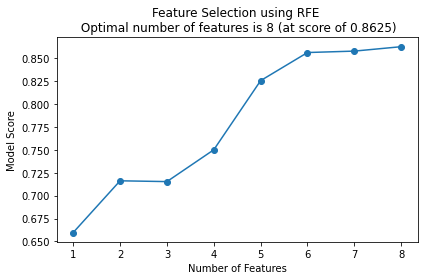

In [76]:
plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), 
         fit.cv_results_['mean_test_score'], 
         marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.cv_results_['mean_test_score']),4)})")
plt.tight_layout()
plt.show()

In [77]:
######################################################
# model train
######################################################
regressor = LinearRegression()
regressor.fit(x_train,y_train)

LinearRegression()

In [78]:
######################################################
# model assessment
######################################################
# Predict on the Test Set 
y_pred = regressor.predict(x_test)

In [79]:
# Calculate R-Squared 
r_squared = r2_score(y_test,y_pred)
print(r_squared)

0.7805702910327413


In [80]:
# Cross Validation 
cv = KFold(n_splits=4,shuffle=True,random_state=42)
cv_scores =cross_val_score(regressor,x_train,y_train,cv=cv,scoring="r2")
print(cv_scores)

[0.8427758  0.86000619 0.8913188  0.81883022]


In [81]:
cv_scores.mean()

0.8532327536589741

In [82]:
# Calculate Adjusted R-Squared
num_data_points, num_input_vars = x_test.shape 
print(x_test.shape) 

(74, 8)


In [84]:
adjusted_r_squared = 1-(1-r_squared)*(num_data_points-1)/(num_data_points-num_input_vars-1)
print(adjusted_r_squared) 

0.7535635576213864


In [86]:
# Extract Model Coefficients
coefficients = pd.DataFrame(regressor.coef_)  
print(coefficients) 

          0
0 -0.201232
1 -0.027697
2  0.000142
3  0.001002
4 -0.004842
5  0.061659
6 -0.003971
7 -0.013393


In [87]:
input_variable_names = pd.DataFrame(x_train.columns)
summary_stats = pd.concat([input_variable_names,coefficients],axis=1)
summary_stats.columns = ['input_variable', 'coefficients']
print(summary_stats)

        input_variable  coefficients
0  distance_from_store     -0.201232
1         credit_score     -0.027697
2          total_sales      0.000142
3          total_items      0.001002
4    transaction_count     -0.004842
5   product_area_count      0.061659
6     avg_basket_value     -0.003971
7             gender_M     -0.013393


In [88]:
# Extract Model Intercept
regressor.intercept_

0.5160974174646102